In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from dataIO import evaluation_entry


from dataIO import loadImgs_plus




In [6]:
class BGNet(nn.Module):
    
    # get 1000 1 6 1 shape
    # predict forground or background
    
    def __init__(self):
        super().__init__()
        
        # set stride , kernel size to 1 at the begining, and tune each layers
        
        # Conv layer 1
        self.conv1 = nn.Conv2d(1,  16, (3, 1), stride = 1, padding = (1, 0))
        self.b_norm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, (3, 1), stride = 1, padding = (0, 0))
        self.b_norm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, (1, 1), stride = 1, padding = (0, 0))
        self.b_norm3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, (1, 1), stride = 1, padding = (0, 0))
        self.b_norm4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, (1, 1), stride = 2, padding = (0, 0))
        self.b_norm5 = nn.BatchNorm2d(256)
        
        self.dropout = nn.Dropout(0.25)
        
        # TODO
        self.fc1 = nn.Linear(512,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)


    def forward(self, inputdata):
        
        # 1000 1 6 1
        #print("Inputdata shape: ",inputdata.shape)
        
        x = inputdata.unsqueeze(-1).unsqueeze(1)
        x = self.conv1(x)
        x = self.b_norm1(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2, 2)
        
        x = self.conv2(x)
        x = self.b_norm2(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2, 2)
        #print(x.shape)
        
        x = self.conv3(x)
        x = self.b_norm3(x)
        x = F.relu(x)
        #x = F.max_pool2d(x, 2, 2)
        
        x = self.conv4(x)
        x = self.b_norm4(x)
        x = F.relu(x)
        
        x = self.conv5(x)
        #print("conv5", x.shape)
        x = self.b_norm5(x)
        x = F.relu(x)
        
        x = x.view(-1, 512) # 扁平化flat然后传入全连接层 ex [1000,256, 2, 1] => 256*2*1

        x = F.relu(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        #random dropout
        #x = self.dropout(x)
        
        x = self.fc5(x)
        
        
        return F.log_softmax(x, dim = 1)





In [7]:
pa_im = '/Users/david/Desktop/venv_enviorments/cmput414_labs/lab1/data/highway/input/'
ft_im = 'jpg'


pa_gt = '/Users/david/Desktop/venv_enviorments/cmput414_labs/lab1/data/highway/groundtruth/'
ft_gt ='png'

imgs = loadImgs_plus(pa_im, ft_im)
gtimgs = loadImgs_plus(pa_gt, ft_gt)


frame, row, column, byte = imgs.shape

crim = imgs.type(torch.FloatTensor)[1000]
bkim = imgs.type(torch.FloatTensor).mean(dim = 0)


inputdata = torch.cat((crim, bkim), dim = 2)
inputdata = inputdata.permute(2, 0, 1).reshape(6, row*column).permute(1, 0)

gtlabs = gtimgs.type(torch.int64)[1000].reshape(row*column)/255
gtlabs = gtlabs.type(torch.int64)


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


#TODO
#network = BGNet().to(device)
network = BGNet().to(device)

optim_net = optim.SGD(network.parameters(), lr= 0.0001, momentum = 0.9)
#optim_net = optim.Adam(network.parameters(), lr = 0.0001)

class_weights = torch.FloatTensor([0.5, 0.5]).to(device)
loss_func = torch.nn.NLLLoss(weight=class_weights, reduction='mean').to(device)



batchsize = 1000
value = round(inputdata.shape[0]/batchsize + 0.5)

# 600 original
epochs = 600

for i in range(epochs):

    totalloss = 0
    for j in range(value):
        data = inputdata[j*batchsize:(j + 1)*batchsize].to(device)
        labs = gtlabs[j*batchsize:(j + 1)*batchsize].to(device)

        output = network(data)

        loss = loss_func(output, labs)

        totalloss = totalloss + loss.item()

        optim_net.zero_grad()   # 梯度归零
        loss.backward(retain_graph = True)
        optim_net.step() # update gradient

    print("epoch:", i, " loss:", totalloss)

    
    
# my test
# TODO
input_test = torch.rand((1000, 6))
net = BGNet()
net.forward(input_test)
print(net)  




loading file: in001700.jpg
loading file: gt001700.png
epoch: 0  loss: 47.990385830402374
epoch: 1  loss: 40.90608596801758
epoch: 2  loss: 34.91574043035507
epoch: 3  loss: 29.828808426856995
epoch: 4  loss: 25.659960463643074
epoch: 5  loss: 22.444495514035225
epoch: 6  loss: 20.091177195310593
epoch: 7  loss: 18.403392523527145
epoch: 8  loss: 17.165518827736378
epoch: 9  loss: 16.20709127932787
epoch: 10  loss: 15.411112554371357
epoch: 11  loss: 14.706602089107037
epoch: 12  loss: 14.049968596547842
epoch: 13  loss: 13.415879491716623
epoch: 14  loss: 12.79892286285758
epoch: 15  loss: 12.199957571923733
epoch: 16  loss: 11.617296051234007
epoch: 17  loss: 11.057292073965073
epoch: 18  loss: 10.537140190601349
epoch: 19  loss: 10.06393737345934
epoch: 20  loss: 9.644206792116165
epoch: 21  loss: 9.278580835089087
epoch: 22  loss: 8.961421070620418
epoch: 23  loss: 8.685381265357137
epoch: 24  loss: 8.442765593528748
epoch: 25  loss: 8.226428978145123
epoch: 26  loss: 8.029446501284

tensor([[-4.7921e-05, -9.9460e+00],
        [ 0.0000e+00, -1.8911e+01],
        [-2.3842e-07, -1.5041e+01],
        ...,
        [-2.3842e-07, -1.5424e+01],
        [-2.3842e-07, -1.5408e+01],
        [-1.1921e-07, -1.5546e+01]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-7.1526e-07, -1.4223e+01],
        [ 0.0000e+00, -1.6845e+01],
        [-1.1921e-07, -1.5666e+01],
        ...,
        [-1.1921e-07, -1.6459e+01],
        [-2.3842e-07, -1.5280e+01],
        [-7.1526e-07, -1.4211e+01]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-1.1921e-07, -1.6112e+01],
        [-1.1921e-07, -1.5768e+01],
        [-1.1921e-07, -1.6335e+01],
        ...,
        [-2.3842e-06, -1.2954e+01],
        [ 0.0000e+00, -1.7759e+01],
        [-1.1921e-07, -1.5694e+01]], grad_fn=<LogSoftmaxBackward0>)
tensor([[ 0.0000e+00, -1.6678e+01],
        [ 0.0000e+00, -1.6938e+01],
        [ 0.0000e+00, -1.8435e+01],
        ...,
        [-5.3332e-04, -7.5367e+00],
        [-1.4424e-05, -1.1149e+01],
        [-7.0927e-05, -9

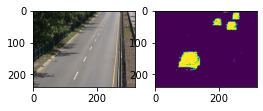

In [8]:
prelabs = torch.abs(gtlabs - gtlabs)
for j in range(value):
    data = inputdata[j*batchsize:(j + 1)*batchsize].to(device)

    output = network(data)
    print(output)

    prelabs[j*batchsize:(j + 1)*batchsize] = output.argmax(dim = 1)


prefgim = prelabs.reshape(row, column)
#gtim = gtimgs.type(torch.int64)[1000]
gtim = gtimgs.type(torch.int64)[1000]

TP, FP, TN, FN = evaluation_entry(prefgim*255, gtim)

Re = TP/(TP + FN)
Pr = TP/(TP + FP)
Fm = (2 * Pr * Re)/(Pr + Re)

print("Re:", Re, " Pr:", Pr, " Fm:", Fm)



fig = plt.figure(figsize = (4,4))

plt.subplot(1, 2, 1)
plt.imshow(bkim.detach().cpu().numpy()/255.0)
plt.subplot(1, 2, 2)
plt.imshow(prefgim.detach().cpu().numpy())
plt.show()


